# ДЗ 8

В 2023 году проходил контест от Телеграма. Нужно было определять язык программирования по сниппету(*)

https://contest.com/docs/ML-Competition-2023

В этой домашке нужно будет решить упрощенную версию этого контеста.

Ограничения:

- Не более 4096 символов на входе
- Не гарантируется, что код на входе синтаксически корректный
- Не гарантируется, что на входе код

Можно использовать любые модели и любые данные.

Важно текстом описать ход решения - как собирали датасет, как процессили данные, какие метрики, какие модели выбрали и почему.

Существует небольшой отложенный датасет, на котором можно будет проверить свое решение после дедлайна.

**Совет: если будете скачивать чатики через скрипты, лучше заведите отдельный аккаунт для этого.**

Возьмём несколько либ с гитхаба (я взял те, что были в трендах) и распарсим их на семплы.

In [6]:
import os
import shutil

import pandas as pd

root_dir = '../data/code_projects/'
python_code_dir = root_dir + 'python_code'
cpp_code_dir = root_dir + 'cpp_code'
js_code_dir = root_dir + 'js_code'
java_code_dir = root_dir + 'java_code'
yaml_code_dir = root_dir + 'yaml_code'
bash_code_dir = root_dir + 'bash_code'
markdown_code_dir = root_dir + 'markdown_code'
c_code_dir = root_dir + 'c_code'
kotlin_code_dir = root_dir + 'kotlin_code'
haskell_code_dir = root_dir + 'haskell_code'

code_dirs = [
    python_code_dir,
    cpp_code_dir,
    js_code_dir,
    java_code_dir,
    yaml_code_dir,
    bash_code_dir,
    markdown_code_dir,
    c_code_dir,
    kotlin_code_dir,
    haskell_code_dir
]

ext_to_dir = {
    'py': python_code_dir,
    'cpp': cpp_code_dir,
    'cxx': cpp_code_dir,
    'hpp': cpp_code_dir,
    'js': js_code_dir,
    'ts': js_code_dir,
    'java': java_code_dir,
    'yaml': yaml_code_dir,
    'sh': bash_code_dir,
    'md': markdown_code_dir,
    'c': c_code_dir,
    'h': c_code_dir,
    'kt': kotlin_code_dir,
    'hs': haskell_code_dir
}

In [2]:
for dir in code_dirs:
    if os.path.exists(dir):
        shutil.rmtree(dir)
    os.makedirs(dir)

for root, dirs, files in os.walk(root_dir):
    if root in code_dirs:
        continue

    for file in files:
        ending = file.split('.')[-1]
        if ending in ext_to_dir:
            src_path = os.path.join(root, file)
            dst_path = os.path.join(ext_to_dir[ending], file)
            shutil.copy(src_path, dst_path)

Теперь возьмём эти файлы и добавим в них шума, чтобы модель могла понимать и нерабочий код. Также, в качестве семплов будем использовать небольшие случайные куски кода (код в снипетах обычно вырван из контекста).

In [3]:
import random

sampled_dirs = [
    python_code_dir + '_sampled',
    cpp_code_dir + '_sampled',
    js_code_dir + '_sampled',
    java_code_dir + '_sampled',
    yaml_code_dir + '_sampled',
    bash_code_dir + '_sampled',
    markdown_code_dir + '_sampled',
    c_code_dir + '_sampled',
    kotlin_code_dir + '_sampled',
    haskell_code_dir + '_sampled'
]

def add_noise(text, noise_level=0.1):
    new_text = ''
    for i in range(len(text)):
        cur = random.random()
        if cur > noise_level or text[i].isspace():
            new_text += text[i]
        else:
            new_text += chr(random.randint(32, 126))
    return new_text

In [4]:
text = 'hello world'
add_noise(text, 0.1)

'hello worlq'

In [5]:

for dir in sampled_dirs:
    if os.path.exists(dir):
        shutil.rmtree(dir)
    os.makedirs(dir)
    
for dir in code_dirs:
    sample_count = 0
    files = os.listdir(dir)
    sampled_dir = dir + '_sampled'
    for file in files:
        real_file = os.path.join(dir, file)
        randomness = 0.0
        with open(real_file, 'r', encoding="utf-8") as fr:
            fw = None
            rnd_row_count = 0
            samples_per_file = 5
            try:
                for line in fr:
                    if rnd_row_count == 0:
                        if fw is not None:
                            fw.close()
                        rnd_row_count = random.randint(8, 30) # снипеты обычно не сильно большие
                        sample_count += 1
                        randomness = max(0.0, min(0.03, 0.001 * sample_count - 0.3)) # Ошибки более 1 уже сложно назвать синтаксическими. Код просто будет нечитаем. Но лимит возьмём в 3 раза больше, чтобы модель имела некторый запас.

                        samples_per_file -= 1
                        if samples_per_file == 0:
                            break

                        ext = file.split('.')[-1]
                        sampled_file = os.path.join(sampled_dir, f'{sample_count}.{ext}')
                        fw = open(sampled_file, 'w', encoding="utf-8")

                    if line.strip() != '':
                        rnd_row_count -= 1

                    fw.write(add_noise(line, randomness))
            except Exception as e:
                print(real_file, ' : ', e)

Теперь загрузим все данный. У меня хватает ОЗУ, однако если бы его не хватило, можно было бы загружать и обычать батчами. 

In [6]:
data = []
labels = {}
labels_count = 0

for dir in sampled_dirs:
    print('reading', dir)
    files = os.listdir(dir)
    labels_count += 1
    labels[dir.split('/')[-1]] = labels_count
    for file in files:
        real_file = os.path.join(dir, file)
        with open(real_file, 'r', encoding="utf-8") as fr:
            text = fr.read()
            data.append({'text': text, 'label': labels_count})

data = pd.DataFrame(data)

reading ../data/code_projects/python_code_sampled
reading ../data/code_projects/cpp_code_sampled
reading ../data/code_projects/js_code_sampled
reading ../data/code_projects/java_code_sampled
reading ../data/code_projects/yaml_code_sampled
reading ../data/code_projects/bash_code_sampled
reading ../data/code_projects/markdown_code_sampled
reading ../data/code_projects/c_code_sampled
reading ../data/code_projects/kotlin_code_sampled
reading ../data/code_projects/haskell_code_sampled


In [7]:
data['real_label'] = data['label'].apply(lambda x: list(labels.keys())[x - 1]).apply(lambda x: x.split('_')[0])
data.to_csv('../data/code_projects_tmp.csv', index=False)

In [8]:
a_data = pd.read_csv('../data/code_projects_tmp.csv')
b_data = pd.read_csv('../data/code_projects.csv')

data = pd.concat([b_data, a_data])
data.to_csv('../data/code_projects.csv', index=False)

In [7]:
data = pd.read_csv('../data/code_projects.csv')
data.head()

,text,label,real_label
0,"#!/usr/bin/env python3\nimport os\n\n""""""\nPlea...",1,python
1,"\t\t\t\t\tnargs='?',\n\t\t\t\t\tmetavar='file'...",1,python
2,"""""""\n\n def __init__(self, ncolors=256,...",1,python
3,"""`sudo apt install pngquant` f...",1,python
4,f.write(' :project: lvgl')\n ...,1,python


In [9]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(data, train_size=0.8, random_state=113)

real_label
js          20298
text        10000
yaml         8635
c            6837
markdown     6692
java         3979
cpp          3060
python       3011
kotlin       2488
haskell      2441
bash         2139
Name: count, dtype: int64


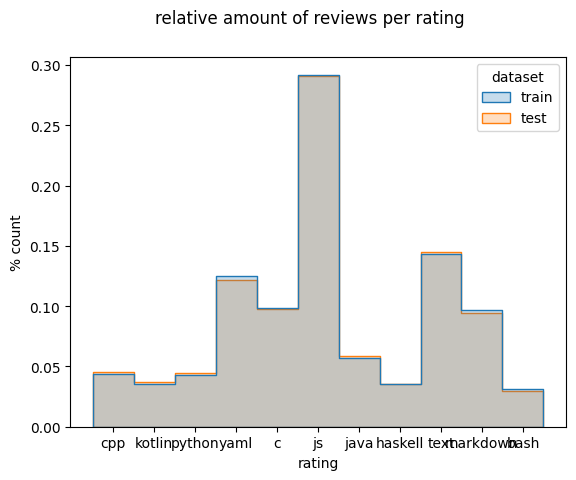

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.suptitle('relative amount of reviews per rating')

train['dataset'] = 'train'
test['dataset'] = 'test'

sns.histplot(
    pd.concat([train, test]),
    x='real_label',
    hue='dataset',
    element="step",
    stat='density',
    common_norm=False
)

plt.ylabel('% count')
plt.xlabel('rating')

cnt = data['real_label'].value_counts()
print(cnt)

Данных получилось даже слишком много

In [13]:
data_ans = pd.read_csv('../data/code_projects/Answers.csv', encoding='latin-1')
data_que = pd.read_csv('../data/code_projects/Questions.csv', encoding='latin-1')

In [15]:
data_ans = data_ans['Body']
data_que = data_que['Body']

0    <p>I am using the Photoshop's javascript API t...
1    <p>I have a cross-platform (Python) applicatio...
2    <p>I'm starting work on a hobby project with a...
3    <p>There are several ways to iterate over a re...
4    <p>I don't remember whether I was dreaming or ...
Name: Body, dtype: object

In [37]:
def code_remover(text):
    import re
    return re.sub(r'<code>(.|\n)*?</code>', '', text)

def tag_remover(text):
    import re
    return re.sub(r'<.*?>', '', text)

def text_cleaner(text):
    return tag_remover(code_remover(text))

data_ans = data_ans.apply(text_cleaner)
data_que = data_que.apply(text_cleaner)

In [42]:
data_ans = data_ans.sample(n=5000, random_state=113)
data_que = data_que.sample(n=5000, random_state=113)

In [45]:
pd.concat([data_ans, data_que]).to_csv('../data/stackoverflow.csv', index=False)

In [51]:
a_data = pd.read_csv('../data/stackoverflow.csv')
b_data = pd.read_csv('../data/code_projects.csv')

a_data['text'] = a_data['Body']
a_data = a_data.drop(columns=['Body'])
a_data['label'] = 0
a_data['real_label'] = 'text'

data = pd.concat([b_data, a_data])
data.to_csv('../data/code_projects.csv', index=False)


## Easy

Учимся отличать код на Python, C++ и JavaScript от обычного текста на английском языке (Other).

Собираем датасет, учим модели, собираем все в скрипт

Должно работать так:

```
$ python main.py python_code.txt
Python
```

Оставить по 3 примера на каждый язык, на которых проверяете решение. Текстовые файлики приложить в репозиторий.

In [11]:
easy_train = train[train['real_label'].isin(['python', 'cpp', 'js', 'text'])]
easy_train = easy_train[['text', 'label']]
easy_train['text'] = easy_train['text'].apply(lambda x: x.lower())
easy_test = test[test['real_label'].isin(['python', 'cpp', 'js', 'text'])]
easy_test = easy_test[['text', 'label']]
easy_test['text'] = easy_test['text'].apply(lambda x: x.lower())

In [13]:
import numpy as np

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression

In [14]:
x_train = np.array(easy_train['text'])
y_train = np.array(easy_train['label'])
x_test = np.array(easy_test['text'])
y_test = np.array(easy_test['label'])

In [15]:
vectorizer = TfidfVectorizer()
x_train = vectorizer.fit_transform(x_train)
x_test = vectorizer.transform(x_test)

In [21]:
model = LogisticRegression(n_jobs=-1, random_state=113, max_iter=10000)
model.fit(x_train, y_train)

LogisticRegression(max_iter=10000, n_jobs=-1, random_state=113)

In [23]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

y_pred = model.predict(x_test)
print(accuracy_score(y_test, y_pred, normalize=True))
confusion_matrix(y_test, y_pred)

0.9796670305676856


array([[1973,    9,    0,   39],
       [   9,  577,    4,   32],
       [   6,    1,  597,   33],
       [  12,    2,    2, 4032]], dtype=int64)

На наших данных работает довольно хорошо. А как работает на реальных данных, узнаем в `medium`


## Medium

Количество языков расширяется до 10

- Python
- C++
- JavaScript
- Java
- Yaml
- Bash
- Markdown
- C
- Kotlin
- Haskell

Какие выводы можно сделать по данным?


In [32]:
medium_train = train[['text', 'label']]
medium_train['text'] = medium_train['text'].astype(str).apply(lambda x: x.lower())
medium_test = test[['text', 'label']]
medium_test['text'] = medium_test['text'].astype(str).apply(lambda x: x.lower())

C:\Users\setday\AppData\Local\Temp\ipykernel_76144\3776038146.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  medium_train['text'] = medium_train['text'].astype(str).apply(lambda x: x.lower())
C:\Users\setday\AppData\Local\Temp\ipykernel_76144\3776038146.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  medium_test['text'] = medium_test['text'].astype(str).apply(lambda x: x.lower())


In [33]:
x_train = np.array(medium_train['text'])
y_train = np.array(medium_train['label'])
x_test = np.array(medium_test['text'])
y_test = np.array(medium_test['label'])

In [35]:
vectorizer = TfidfVectorizer()
x_train = vectorizer.fit_transform(x_train)
x_test = vectorizer.transform(x_test)

In [36]:
model = LogisticRegression(n_jobs=-1, random_state=113, max_iter=1000)
model.fit(x_train, y_train)

LogisticRegression(max_iter=1000, n_jobs=-1, random_state=113)

In [43]:
data_labels = data[['real_label', 'label']].drop_duplicates()
data_labels = data_labels.set_index('label').to_dict()['real_label']
data_labels

{1: 'python',
 2: 'cpp',
 3: 'js',
 4: 'java',
 5: 'yaml',
 6: 'bash',
 7: 'markdown',
 8: 'c',
 9: 'kotlin',
 10: 'haskell',
 0: 'text'}

In [44]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

y_pred = model.predict(x_test)
print(accuracy_score(y_test, y_pred, normalize=True))
print(confusion_matrix(y_test, y_pred))
print([data_labels[x] for x in range(10)])

0.9498419085944236
[[1954    9    0   13    0    3    0   40    1    1    0]
 [   5  557    1   19    0    3    2   29    5    0    1]
 [   5    0  525   14    1    0    0   16   75    1    0]
 [   6    2    3 3981    2    4    0   46    1    0    3]
 [   7    2    0   16  767    2    0   12    4    1    0]
 [   5    0    0    4    5 1653    3   21    1    0    1]
 [   2    0    2    0    2    1  377   26    0    0    0]
 [  26    7    3    6   11    4    3 1248    0    0    2]
 [   5    3   67    8    0    1    0   16 1255    0    1]
 [   5    0    0   15    5    2    0   14    0  477    0]
 [  16    1    0    6    0    4    0   35    3    1  424]]
['text', 'python', 'cpp', 'js', 'java', 'yaml', 'bash', 'markdown', 'c', 'kotlin']


Моделька очень часто не понимает, что перед ней файл `markdown`. Не сказал бы, что это супер очевидно, но наверное это произошло из-за недообучения, а возможно и из-за текста разных языков. В любом случае, скоры очень хорошие, даже для `markdown` Ошибка не более `25 %`.

In [51]:
medium_test[medium_test['label'] == 7]

,text,label
39988,# git show-branch\n\n> da?ları ve içerdikleri ...,7
39128,# doctl account\n\n> retrieve informateon abou...,7
39764,\n`arduino-builder -verbose {{true}}`\n,7
39334,# esearch\n\n> perform a new entrez search usf...,7
41615,# nsenter\n\n> run a new commanv in a running ...,7
...,...,...
39009,# dirnaze\n\n> belirtilen dosya veya yolun ana...,7
40690,\n9isutf8 --invert {{path/to/file1 path|to/fil...,7
43480,# takeout\n\n> ` docker-based development-only...,7
44766,# cryptsetup\n\n> 管理普e dm-crypt 和 luks（linuz 统...,7


In [54]:
import pickle

with open('../py_code/08-homework/model/model_recognize_language.pkl', 'wb') as f:
    pickle.dump(model, f)
with open('../py_code/08-homework/model/vectorizer_recognize_language.pkl', 'wb') as f:
    pickle.dump(vectorizer, f)

Теперь провалидируем на реальных данных

## Hard

Добавляется ограничение на скорость. Каждый запуск должен быть гарантированно не дольше 10мс.

В этом харде можно писать код на любых языках.

---

(\*) сниппетом называется все, что оборачивается в тройные тильды (```)